In [276]:
import numpy as np
import numpy.linalg as LA
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
import pickle # for hacky deep copy
import random

# Project introduction:
## 1. Environment: a maze
A simple maze with 10x10 cells in default setting (scalable), with some cells are "Wall". The wall was put manually at first for testing. After that, I intened to make a function to generate wall randomly. However, to change the walls randomly, I need another algorithm to make sure the maze is solvable (randomized walls can some time blocks the door). Therefore, in this maze, the wall was manually put by hand in the way that guarantee the maze is always solvable.
    
    
The **agent** start at "start_position", which is random generated. First, the agent need to move to get the "key", which is also random generated, then, with the key in hand, finally the agent can exit the maze by going to the "door", which is also random generated.
    
    
The agent has four posibile **action**, going UP, DOWN, LEFT, RIGHT. If the agent want to move to the wall, or to the border of the maze, the agent return to its previous position.
    

In [277]:
RANDOM = True
rows_count = 10
columns_count = 10

gamma = 1
alpha = 0.2
episode = 200 #episode to train. Need to change this to higher if the maze size is bigger than 10x10
maxStep = 300 #Maximum steps in 1 episode. Need to change this to higher if the maze size is bigger than 10x10
epsilon = 0.4 #doesn't need to change it here, since epsilon change itself base on episode

if (random):
    start_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
    
    terminating = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]    
    while(terminating==start_position):
        terminating = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
        
    key_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
    while((key_position==terminating) or (key_position==start_position)):
        key_position = [(random.randint(0, rows_count-1), (random.randint(0, columns_count-1)))]
            
else:
    start_position = [(0,0)]
    terminating = [(9,9)]
    key_position = [(0,8)]
                         
                         
                        
DOOR = "D"
START = "S"
EMPTY = "E"
WALL = "W"
KEY = "K"
PATH = "P"
UP = 0
DOWN = 1
LEFT = 2
RIGHT = 3
stepcost = -1

def generateTestMaze():
    V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    V.fillna(EMPTY, inplace=True)
    V.iloc[0][1] = WALL
    V.iloc[1][1] = WALL
    V.iloc[2][1] = WALL
    
    V.iloc[1][3] = WALL
    V.iloc[1][5] = WALL
    V.iloc[1][6] = WALL
    
    V.iloc[4][0] = WALL
    V.iloc[4][1] = WALL
    V.iloc[4][2] = WALL
    V.iloc[4][3] = WALL    
    V.iloc[4][5] = WALL
    V.iloc[4][6] = WALL
    V.iloc[4][7] = WALL
    V.iloc[4][8] = WALL
    
    V.iloc[5][5] = WALL                
    V.iloc[5][8] = WALL
    
    V.iloc[6][1] = WALL
    V.iloc[6][2] = WALL
    V.iloc[7][2] = WALL
    V.iloc[8][2] = WALL
    V.iloc[9][2] = WALL
    V.iloc[6][7] = WALL
   
    
    V.iloc[7][4] = WALL
    V.iloc[7][5] = WALL
    V.iloc[7][6] = WALL
    
    V.iloc[8][8] = WALL
    V.iloc[9][8] = WALL
    
    V.iloc[0][7] = WALL
    V.iloc[1][7] = WALL
    V.iloc[2][7] = WALL    
    
    V.iloc[key_position[0][0]][key_position[0][1]] = KEY
    V.iloc[terminating[0][0]][terminating[0][1]] = DOOR
    V.iloc[start_position[0][0]][start_position[0][1]] = START
    return V
    

maze = generateTestMaze()
print(maze)

   0  1  2  3  4  5  6  7  8  9
0  E  W  E  E  E  E  E  W  E  E
1  E  W  E  W  E  W  W  W  E  E
2  E  W  E  E  E  E  E  W  E  E
3  E  E  E  E  E  E  E  E  E  E
4  W  W  W  W  E  W  W  W  W  E
5  E  E  E  E  E  W  E  E  W  E
6  E  W  W  E  E  E  E  W  E  E
7  E  E  W  S  W  W  W  E  D  E
8  E  E  W  E  E  E  E  E  W  E
9  E  E  W  E  E  E  E  E  K  E


(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

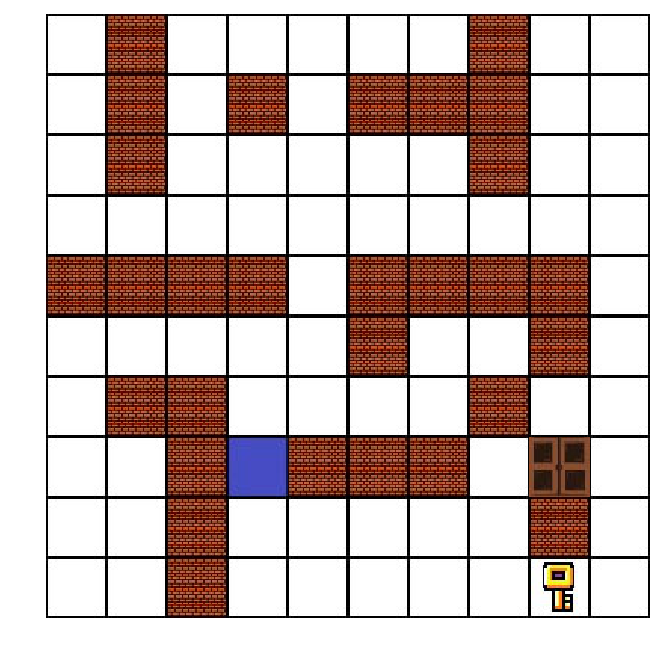

In [278]:
def arrayToImage(array, ncols=10):
    """
    Function help to convert array (which contain image info) to image
    """
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result


def makeImageArray(start, dataframe):
    """
    Function help to convert dataframe to an array which contain the image info
    """
    if (dataframe.iloc()[0][0] == DOOR):
        imageArray = np.array([np.asarray(Image.open('images/door.jpg').convert('RGB'))])
    elif (dataframe.iloc()[0][0] == KEY):
        imageArray = np.array([np.asarray(Image.open('images/key.jpg').convert('RGB'))])
    elif (dataframe.iloc()[0][0] == START):
        imageArray = np.array([np.asarray(Image.open('images/path.jpg').convert('RGB'))])
    else:
        imageArray = np.array([np.asarray(Image.open('images/empty.jpg').convert('RGB'))])
        
    for i in range(rows_count):
        for j in range(columns_count):
            #skip the first cell, since we already add it in the begining
            if (i!=0) or (j!=0):                
                path = "images/empty.jpg"
                if dataframe.iloc()[i][j] == WALL:
                    path = "images/wall.jpg"
                elif dataframe.iloc()[i][j] == DOOR:
                    path = "images/door.jpg"
                elif dataframe.iloc()[i][j] == PATH:
                    path = "images/path.jpg"
                elif dataframe.iloc()[i][j] == KEY:
                    path = "images/key.jpg"
                imageArray = np.append(imageArray, [np.asarray(Image.open(path).convert('RGB'))], axis=0)  
    
    path = "images/path.jpg"
    imageArray[start[0][0]*rows_count+start[0][1]] = np.asarray(Image.open(path).convert('RGB'))
    
    return imageArray

def showMaze(array):
    """
    Function help print the image with a proper format
    """
    print(array.shape)
    result = arrayToImage(array)
    plt.figure(2)
    fig=plt.figure(figsize=(8, 8), dpi = 100)
    plt.imshow(result)
    plt.axis('off')    
    plt.show()        

array = makeImageArray(start_position, maze)
showMaze(array)

## 2. Algorithm: Sarsa (on-policy TD control)

### 2.1 Method
I used Reinforcement Learning book by Richard Sutton and Andrew Barto formular on page 131. I first use it to solve the Windy World problem. And then apply it here to solve the maze problem.

One extra problem is, since the agent need to get both key and door to exit the maze, if the path to the key and door are overlapsed, the agent can't remember/decide which action is the best, base on Q alone. For example, without the key, the agent need to go up in: row 7 column 9, after that, it need to go down to row 8, column 9. So, Q matrix with state and action need another dimension to store the **key** variable.

Instead of adding another dimension to my Q matrix, I divide the problem into 2 smaller one: first I solve the problem to go from the starting position to the key position, then I solve the second problem of going from the key position to the door position.

So, this maze was solve by training the model to reach the key, then train another model to reach the door. By doing so, I can reuse most of my code, and don't need to change the core concept of the algorithm

In [279]:
def epsilon_greedy(Q, epsilon, row, column):
    """
    Function help select the action based on the epsilon greedy policy
    """
    if np.random.rand() < epsilon:
        actIndex = Q.iloc()[row][column].index(max(Q.iloc()[row][column]))        
    else:
        actIndex = random.choice([UP, DOWN, LEFT, RIGHT])    
    
    return actIndex

def valueForMaze(row, column, action, maze, ending): 
    """
    @param row
    @param column
    @param action
    @param maze
    
    Make sure that the action don't make you step out of the array bondary [0, rows_count-1] or [0, columns_count-1]
    Some codes look like it doesn't do anything (actionColumn = max(column, 0)), but it actually does something
    in other scenario (column was change because of "Wind blow left", so just leave it there)
    """
    if (row,column) in ending:
        return 0, 0, 0    
    else:        
        if (action == UP):
            actionRow = max(min(row-1, rows_count-1), 0)
            actionColumn = max(min(column, columns_count-1),0)
        elif (action == DOWN) :
            actionRow = max(min(row+1, rows_count-1),0)
            actionColumn = max(min(column, columns_count-1),0)
        elif (action == LEFT) :
            actionRow = max(min(row, rows_count-1),0)
            actionColumn = max(column-1, 0)
        elif (action == RIGHT) :
            actionRow = max(min(row, rows_count-1),0)
            actionColumn = max(min(column+1, columns_count-1),0)
        
        #Check if step into wall
        if (maze.iloc()[actionRow][actionColumn]) == "W":
            return stepcost, row, column
        else:
            return stepcost, actionRow, actionColumn

def training(rows_count, columns_count, episode, maxStep, start, ending, epsilon, gamma, alpha, maze):
    """
    Function help train the data, using 
    """
    #Initialize Q(s,a):
    random.seed(2705)
    Q = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    for i in range(rows_count):
        for j in range (columns_count):
            Q.iloc()[i][j] = [0, 0, 0, 0]
    
    for i in tqdm(range(episode)):
        #initialize stage S:
        #row = random.randint(0, rows_count-1)
        #column = random.randint(0, columns_count-1)
        row = start[0][0]
        column = start[0][1]

        #If the result is wall, do it again
        """
        while (maze.iloc()[row][column] == "W"):
            row = random.randint(0, rows_count-1)
            column = random.randint(0, columns_count-1)                            
        """

        step = 1
        if (i<episode*0.2):
            epsilon = 0.05
        elif (i<episode*0.4):
            epsilon = 0.2
        elif (i<episode*0.6):
            epsilon = 0.4
        elif (i<episode*0.8):                
            epsilon = 0.6
        else:
            epsilon = 0.8

        #Choose action A from state S using policy derived from Q (e.g., epsilon-greedy)
        action = epsilon_greedy(Q, epsilon, row, column)

        while(step < maxStep):
            #Until S is terminal
            if (row,column) in ending:
                break

            #Take action A, observe R (reward) and new state S':
            reward, newRow, newColumn = valueForMaze(row, column, action, maze, ending)

            #Choose action A' from state S' using policy derived from Q (e.g., epsilon-greedy)
            newAction = epsilon_greedy(Q, epsilon, newRow, newColumn)        

            #Q(S,A) <- Q(S,A) + alpha*[R + gamma*Q(S',A') - Q(S,A)]
            Q.iloc()[row][column][action] = Q.iloc()[row][column][action] +\
                alpha*(reward + gamma*Q.iloc()[newRow][newColumn][newAction] - Q.iloc()[row][column][action])
            row = newRow
            column = newColumn
            action = newAction
            step+=1

    return Q


In [280]:
#train the model to get keys
Qkey = training(rows_count, columns_count, episode, maxStep, start_position, key_position, epsilon, gamma, alpha, maze)

100%|██████████| 200/200 [00:12<00:00, 15.67it/s]


In [281]:
#train the model to go to the door
Qdoor = training(rows_count, columns_count, episode, maxStep, key_position, terminating, epsilon, gamma, alpha, maze)

100%|██████████| 200/200 [00:06<00:00, 28.72it/s]


In [282]:
def generateResultMaze(qDF, baseMaze, start, ending):
    myMaze = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
    myMaze.fillna(EMPTY, inplace=True)
    row = start[0][0]
    column = start[0][1]
    myMaze.iloc()[row][column] = PATH
    
    maxLength = rows_count*columns_count*10
    step = 0
    
    #Put in the correct path
    while (((row,column) not in ending) and (step < maxLength)):
        actIndex = qDF.iloc()[row][column].index(max(qDF.iloc()[row][column]))
        print("Row: {0:2d}, Column: {1:2d}, Action: {2:5s}".format(row, column, ACTION_LIST[actIndex])) 
        
        if (actIndex == 0):
            row = max(row - 1, 0)
        elif (actIndex == 1):
            row = min(row + 1, rows_count-1)
        elif (actIndex == 2):
            column = max(column - 1, 0)
        else:
            column = min(column + 1, columns_count-1)
        myMaze.iloc()[row][column] = PATH
        step = step + 1
        if (step==maxLength):
            print("Failed to find the exit after walk for {} times".format(step))
    
    print("Total steps took: {}".format(step))
    #Put in the wall
    for i in range(rows_count):
        for j in range (columns_count):
            if (baseMaze.iloc()[i][j] == WALL):
                myMaze.iloc()[i][j] = WALL
            if (baseMaze.iloc()[i][j] == DOOR):
                myMaze.iloc()[i][j] = DOOR
            if (baseMaze.iloc()[i][j] == KEY):
                myMaze.iloc()[i][j] = KEY
                
    return myMaze

In [283]:
ACTION_LIST = ["UP", "DOWN", "LEFT", "RIGHT"]
print("-------------------------GO TO KEY-----------------------------")
print(" ")
V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))

for i in range(rows_count):
    for j in range (columns_count):
        actIndex = Qkey.iloc()[i][j].index(max(Qkey.iloc()[i][j]))
        V.iloc()[i][j] = ACTION_LIST[actIndex]

V.iloc()[start_position[0][0]][start_position[0][1]] = "-| |-"            
V.iloc()[key_position[0][0]][key_position[0][1]] = "--X--"    
print(V)
print(" ")
print("-------------------------GO TO DOOR-----------------------------")
print(" ")
V = pd.DataFrame(index=range(rows_count), columns=range(columns_count))
for i in range(rows_count):
    for j in range (columns_count):
        actIndex = Qdoor.iloc()[i][j].index(max(Qdoor.iloc()[i][j]))
        V.iloc()[i][j] = ACTION_LIST[actIndex]

V.iloc()[key_position[0][0]][key_position[0][1]] = "-| |-"    
V.iloc()[terminating[0][0]][terminating[0][1]] = "--X--"    
print(V)

-------------------------GO TO KEY-----------------------------
 
       0      1      2      3      4      5      6      7      8     9
0  RIGHT     UP     UP   LEFT     UP     UP  RIGHT     UP   DOWN    UP
1     UP     UP     UP     UP   DOWN     UP     UP     UP     UP  LEFT
2     UP     UP   DOWN  RIGHT   DOWN  RIGHT   LEFT     UP     UP    UP
3     UP   LEFT   LEFT     UP   LEFT  RIGHT     UP  RIGHT   LEFT  DOWN
4     UP     UP     UP     UP     UP     UP     UP     UP     UP  DOWN
5   DOWN   DOWN  RIGHT  RIGHT     UP     UP   LEFT   LEFT     UP  DOWN
6   DOWN     UP     UP     UP     UP   DOWN  RIGHT     UP     UP  DOWN
7  RIGHT  RIGHT     UP  -| |-     UP     UP     UP  RIGHT  RIGHT  DOWN
8     UP  RIGHT     UP  RIGHT  RIGHT  RIGHT  RIGHT   DOWN     UP  DOWN
9  RIGHT  RIGHT     UP  RIGHT  RIGHT  RIGHT  RIGHT  RIGHT  --X--  LEFT
 
-------------------------GO TO DOOR-----------------------------
 
       0     1      2      3      4      5      6      7      8      9
0   LEFT    U

## 2. Algorithm: Sarsa (on-policy TD control)

### 2.2 Result

Generally, it took about **40~45 seconds** to solve the maze. Sometime you get lucky when the key/door is located near the starting point, then you get the result faster. On average I believe it never pass 60 second.

Instead of calculate the delta of Q matrix (it would slow down the algorithm since you'll need to loop throught the state and action as well, it's will slow because I store the Q value in dataframe - easy to see but slow when compute)
to see the convergence, I set the fixed episode of **200** times to guarantee the Q matrix will converge by then.

I tested many cases and so far, with 200 episode and 300 max step per episode, and 300 maximum steps per episode, it can solve all cases of 10x10 maze.

(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

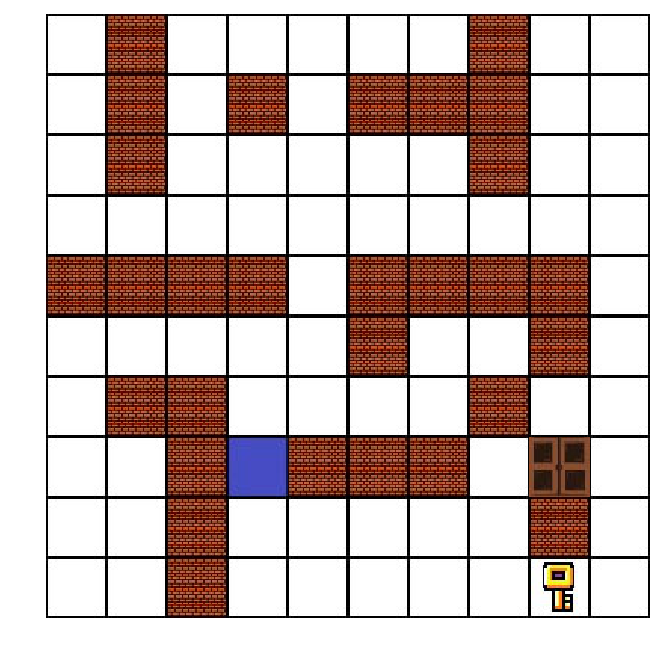

In [284]:
array = makeImageArray(start_position, maze)
showMaze(array)

Row:  7, Column:  3, Action: DOWN 
Row:  8, Column:  3, Action: RIGHT
Row:  8, Column:  4, Action: RIGHT
Row:  8, Column:  5, Action: RIGHT
Row:  8, Column:  6, Action: RIGHT
Row:  8, Column:  7, Action: DOWN 
Row:  9, Column:  7, Action: RIGHT
Total steps took: 7
(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

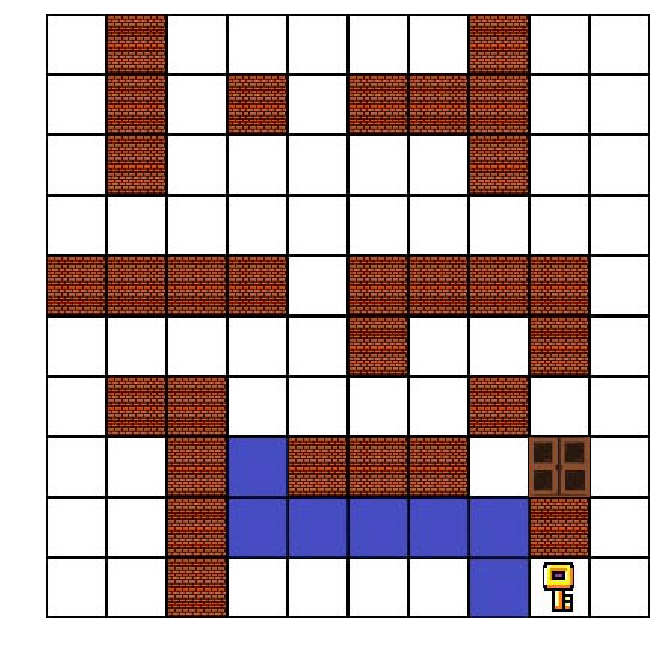

In [285]:
mazeKey = generateResultMaze(Qkey, maze, start_position, key_position)
resultKey = makeImageArray(start_position, mazeKey)
showMaze(resultKey)

Row:  9, Column:  8, Action: RIGHT
Row:  9, Column:  9, Action: UP   
Row:  8, Column:  9, Action: UP   
Row:  7, Column:  9, Action: LEFT 
Total steps took: 4
(100, 40, 40, 3)


<Figure size 432x288 with 0 Axes>

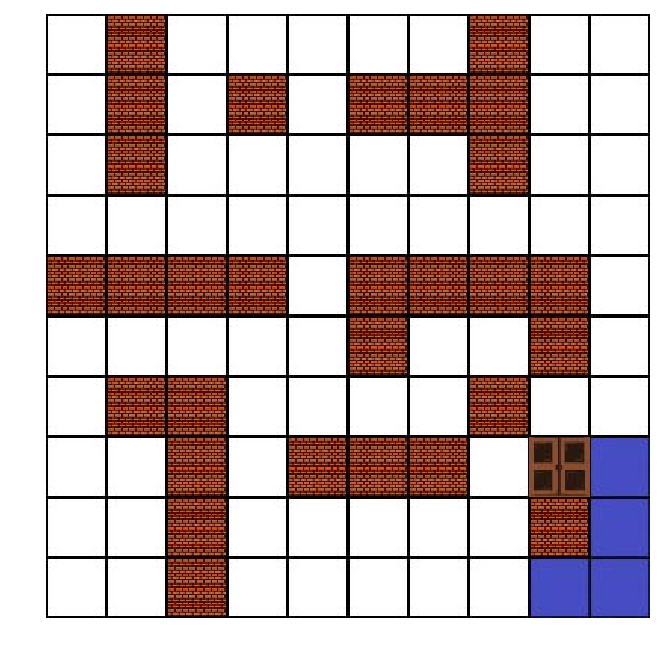

In [286]:
mazeDoor = generateResultMaze(Qdoor, maze, key_position, terminating)
resultDoor = makeImageArray(key_position, mazeDoor)
showMaze(resultDoor)